In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
import os
#read file 
root = os.getcwd()
File = '/newData_Feb11.csv'
df = pd.read_csv(root+File)
#set date as index
df=df.set_index('Date')
df.head(10)

,RAY,VIX,QQQ,T10Y3M,CL1,HG1,GC1,XAG,VNQ,EURtoUSD,VXUS,EEM
Date,,,,,,,,,,,,
1990-01-02,200.241,17.24,NaN,0.11,NaN,NaN,NaN,NaN,NaN,1.2146,NaN,NaN
1990-01-03,200.116,18.19,NaN,0.10,NaN,NaN,NaN,NaN,NaN,1.2096,NaN,NaN
1990-01-04,198.646,19.22,NaN,0.14,NaN,NaN,NaN,NaN,NaN,1.2287,NaN,NaN
1990-01-05,196.850,20.11,NaN,0.20,NaN,NaN,NaN,NaN,NaN,1.2358,NaN,NaN
1990-01-08,197.525,20.26,NaN,0.23,NaN,NaN,NaN,NaN,NaN,1.2452,NaN,NaN
1990-01-09,195.549,22.20,NaN,0.22,NaN,NaN,NaN,NaN,NaN,1.2356,NaN,NaN
1990-01-10,194.112,22.44,NaN,0.28,NaN,NaN,NaN,NaN,NaN,1.2361,NaN,NaN
1990-01-11,194.645,20.05,NaN,0.24,23.14,109.2,415.6,5.31,NaN,1.2367,NaN,NaN
1990-01-12,190.094,24.64,NaN,0.36,23.13,105.9,414.7,5.33,NaN,1.2409,NaN,NaN


In [2]:
def first_valid_table(dataframe):   
    first_valid = pd.DataFrame(columns=[None,'First valid date','Total N/A','N/A since first valid'])
    for i in range(len(dataframe.columns)):
        col=dataframe.columns[i]
        #first obs date
        first_date = dataframe[col].first_valid_index()
        #Total NA
        total_NA = dataframe[col].isnull().sum(axis = 0)
        #NA since first_date
        NA_count = dataframe[dataframe.index >= first_date][col].isnull().sum(axis = 0)
        first_valid.loc[i]= [col,first_date,total_NA,NA_count]

    first_valid.set_index(None,inplace= True)
    first_valid.sort_values(by = "First valid date",inplace=True)
    return first_valid
display(first_valid_table(df))

,First valid date,Total N/A,N/A since first valid
RAY,1990-01-02,286,286
VIX,1990-01-02,297,297
T10Y3M,1990-01-02,9,9
EURtoUSD,1990-01-02,79,79
CL1,1990-01-11,320,313
HG1,1990-01-11,319,312
GC1,1990-01-11,320,313
XAG,1990-01-11,62,55
QQQ,1999-03-10,2615,219
EEM,2003-07-01,3690,170


In [3]:
#forward fill
df.ffill(inplace= True)

In [4]:
#check again after ffill
display(first_valid_table(df))

,First valid date,Total N/A,N/A since first valid
RAY,1990-01-02,0,0
VIX,1990-01-02,0,0
T10Y3M,1990-01-02,0,0
EURtoUSD,1990-01-02,0,0
CL1,1990-01-11,7,0
HG1,1990-01-11,7,0
GC1,1990-01-11,7,0
XAG,1990-01-11,7,0
QQQ,1999-03-10,2396,0
EEM,2003-07-01,3520,0


In [5]:
#partial difference
#article source: https://www.kaggle.com/elvisesp/time-series-analysis-using-fractional-differencing
#code source: https://gist.github.com/skuttruf/fb82807ab0400fba51c344313eb43466
import statsmodels
from statsmodels.tsa.stattools import adfuller

#run adf test for initial time series from first valid
def adf_table(dataframe):
    adf = pd.DataFrame(columns=[None,'ADF Statistic','ADF p-value','Reject H0 at 5%?'])
    for i in range(len(dataframe.columns)):
        col=dataframe.columns[i]
        #first obs date
        first_date = dataframe[col].first_valid_index()
        series = dataframe[dataframe.index >= first_date][col]
        adftest=adfuller(series)
        reject = "No"
        if adftest[1] < 0.05:
            reject = "Yes"
        adf.loc[i]= [col,round(adftest[0],4),round(adftest[1],4),reject]
    adf.set_index(None,inplace= True)
    return adf
display(adf_table(df))

,ADF Statistic,ADF p-value,Reject H0 at 5%?
RAY,2.5652,0.9991,No
VIX,-6.6609,0.0000,Yes
QQQ,3.5200,1.0000,No
T10Y3M,-2.4525,0.1275,No
CL1,-2.1155,0.2383,No
HG1,-0.9819,0.7598,No
GC1,0.2328,0.9740,No
XAG,-1.3109,0.6242,No
VNQ,-1.0523,0.7337,No
EURtoUSD,-2.2805,0.1783,No



Since partial differentiation is expensive, we use log transformation to partly stationarize the time series first
for better convergence in Partial diff. 
We note that the problem with log transform is it does not take care of negative value.
T10Y3M and CL1 have this problem.
T10Y3M is the spread between 10Y and 3M bond yields so it can be negative.
CL1 is crude oil and in 2020 we had the negative price for the first time in history.
using log transform on these two will lose information. So we won't transform it.
Since VIX is already unit-root stationary, we do not need to further transform it. We create new log dataframe of other vars.

In [6]:
#log transform our dataset except for VIX, T10Y3M, CL1
df_log = np.log(df.drop(['VIX','T10Y3M','CL1'], axis=1).copy(deep=True))
display(df_log)

,RAY,QQQ,HG1,GC1,XAG,VNQ,EURtoUSD,VXUS,EEM
Date,,,,,,,,,
1990-01-02,5.299522,NaN,NaN,NaN,NaN,NaN,0.194415,NaN,NaN
1990-01-03,5.298897,NaN,NaN,NaN,NaN,NaN,0.190290,NaN,NaN
1990-01-04,5.291524,NaN,NaN,NaN,NaN,NaN,0.205957,NaN,NaN
1990-01-05,5.282442,NaN,NaN,NaN,NaN,NaN,0.211719,NaN,NaN
1990-01-08,5.285865,NaN,NaN,NaN,NaN,NaN,0.219296,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-02-07,7.875294,5.896384,6.093795,7.494708,3.119895,4.662117,0.119204,4.126650,3.882800
2022-02-08,7.875294,5.896384,6.093795,7.494708,3.119895,4.662117,0.119204,4.132443,3.892432
2022-02-09,7.875294,5.896384,6.093795,7.494708,3.119895,4.662117,0.119204,4.148675,3.908015


In [8]:
#test if log transform caused new missing value
display(first_valid_table(df_log))
#all good
#test adf for log dataframe
display(adf_table(df_log))

,First valid date,Total N/A,N/A since first valid
RAY,1990-01-02,0,0
EURtoUSD,1990-01-02,0,0
HG1,1990-01-11,7,0
GC1,1990-01-11,7,0
XAG,1990-01-11,7,0
QQQ,1999-03-10,2396,0
EEM,2003-07-01,3520,0
VNQ,2004-09-29,3846,0
VXUS,2011-01-28,5498,0


,ADF Statistic,ADF p-value,Reject H0 at 5%?
RAY,-0.5816,0.8751,No
QQQ,0.5670,0.9868,No
HG1,-0.8326,0.8094,No
GC1,0.1052,0.9664,No
XAG,-0.9687,0.7645,No
VNQ,-1.6015,0.4828,No
EURtoUSD,-2.1882,0.2105,No
VXUS,-1.9779,0.2964,No
EEM,-3.2432,0.0176,Yes


After the log transformation, we observe the ADF Statistic of our variables. Most of the t-stats improved to nearer satisfied the critical value for rejecting the null hypothesis. Note that log(EEM) is now stationary.

In [12]:
#code for partial differentiation
#get the weights of past data for each data point
def getWeights(d,lags):
    # return the weights from the series expansion of the differencing operator
    # for real orders d and up to lags coefficients
    w=[1]
    for k in range(1,lags):
        w.append(-w[-1]*((d-k+1))/k)
    w=np.array(w).reshape(-1,1) 
    return w


def plotWeights(dRange, lags, numberPlots):
    weights=pd.DataFrame(np.zeros((lags, numberPlots)))
    interval=np.linspace(dRange[0],dRange[1],numberPlots)
    for i, diff_order in enumerate(interval):
        weights[i]=getWeights(diff_order,lags)
    weights.columns = [round(x,2) for x in interval]
    fig=weights.plot(figsize=(15,6))
    plt.legend(title='Order of differencing')
    plt.title('Lag coefficients for various orders of differencing')
    plt.xlabel('lag coefficients')
    #plt.grid(False)
    plt.show()
    
    
def cutoff_find(order,cutoff,start_lags): #order is our dearest d, cutoff is 1e-5 for us, and start lags is an initial amount of lags in which the loop will start, this can be set to high values in order to speed up the algo
    val=np.inf
    lags=start_lags
    while abs(val)>cutoff:
        w=getWeights(order, lags)
        val=w[len(w)-1]
        lags+=1
    return lags


def ts_differencing_tau(series, order, tau):
    # return the time series resulting from (fractional) differencing
    lag_cutoff=(cutoff_find(order,tau,1)) #finding lag cutoff with tau
    weights=getWeights(order, lag_cutoff)
    res=0
    for k in range(lag_cutoff):
        res += weights[k]*series.shift(k).fillna(0)
    return res[lag_cutoff:]


In [18]:
#create pre part-diff dataframe
#drop EEM from df_log and join with df[['T10Y3M','CL1']]
df_prepd=pd.concat([df_log.drop('EEM',axis=1), df[['T10Y3M','CL1']]], axis=1)
display(df_prepd)
display(df_log.drop('EEM',axis=1))
display(df[['T10Y3M','CL1']])

,RAY,QQQ,HG1,GC1,XAG,VNQ,EURtoUSD,VXUS,T10Y3M,CL1
Date,,,,,,,,,,
1990-01-02,5.299522,NaN,NaN,NaN,NaN,NaN,0.194415,NaN,0.11,NaN
1990-01-03,5.298897,NaN,NaN,NaN,NaN,NaN,0.190290,NaN,0.10,NaN
1990-01-04,5.291524,NaN,NaN,NaN,NaN,NaN,0.205957,NaN,0.14,NaN
1990-01-05,5.282442,NaN,NaN,NaN,NaN,NaN,0.211719,NaN,0.20,NaN
1990-01-08,5.285865,NaN,NaN,NaN,NaN,NaN,0.219296,NaN,0.23,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-02-07,7.875294,5.896384,6.093795,7.494708,3.119895,4.662117,0.119204,4.126650,1.57,88.21
2022-02-08,7.875294,5.896384,6.093795,7.494708,3.119895,4.662117,0.119204,4.132443,1.57,88.21
2022-02-09,7.875294,5.896384,6.093795,7.494708,3.119895,4.662117,0.119204,4.148675,1.57,88.21


,RAY,QQQ,HG1,GC1,XAG,VNQ,EURtoUSD,VXUS
Date,,,,,,,,
1990-01-02,5.299522,NaN,NaN,NaN,NaN,NaN,0.194415,NaN
1990-01-03,5.298897,NaN,NaN,NaN,NaN,NaN,0.190290,NaN
1990-01-04,5.291524,NaN,NaN,NaN,NaN,NaN,0.205957,NaN
1990-01-05,5.282442,NaN,NaN,NaN,NaN,NaN,0.211719,NaN
1990-01-08,5.285865,NaN,NaN,NaN,NaN,NaN,0.219296,NaN
...,...,...,...,...,...,...,...,...
2022-02-07,7.875294,5.896384,6.093795,7.494708,3.119895,4.662117,0.119204,4.126650
2022-02-08,7.875294,5.896384,6.093795,7.494708,3.119895,4.662117,0.119204,4.132443
2022-02-09,7.875294,5.896384,6.093795,7.494708,3.119895,4.662117,0.119204,4.148675


,T10Y3M,CL1
Date,,
1990-01-02,0.11,NaN
1990-01-03,0.10,NaN
1990-01-04,0.14,NaN
1990-01-05,0.20,NaN
1990-01-08,0.23,NaN
...,...,...
2022-02-07,1.57,88.21
2022-02-08,1.57,88.21
2022-02-09,1.57,88.21


In [19]:
#check if joining cause any missing value, it should not
display(first_valid_table(df_prepd))
#it look good
display(adf_table(df_prepd))

,First valid date,Total N/A,N/A since first valid
RAY,1990-01-02,0,0
EURtoUSD,1990-01-02,0,0
T10Y3M,1990-01-02,0,0
HG1,1990-01-11,7,0
GC1,1990-01-11,7,0
XAG,1990-01-11,7,0
CL1,1990-01-11,7,0
QQQ,1999-03-10,2396,0
VNQ,2004-09-29,3846,0
VXUS,2011-01-28,5498,0


,ADF Statistic,ADF p-value,Reject H0 at 5%?
RAY,-0.5816,0.8751,No
QQQ,0.5670,0.9868,No
HG1,-0.8326,0.8094,No
GC1,0.1052,0.9664,No
XAG,-0.9687,0.7645,No
VNQ,-1.6015,0.4828,No
EURtoUSD,-2.1882,0.2105,No
VXUS,-1.9779,0.2964,No
T10Y3M,-2.4525,0.1275,No
CL1,-2.1155,0.2383,No


In [39]:
possible_d=np.divide(range(1,100),100)
tau=1e-4
best_d = 0
df_postpd=df_prepd.copy(deep=True)
adf_stat_holder=[None]*len(possible_d)

In [ ]:
#CAUTION: This code takes a long time to run
#run pd on QQQ for graphing
one_time=0
#first valid index for QQQ
QQQ_first = df_prepd['QQQ'].first_valid_index()
for i in range(len(possible_d)):
    pd_series=ts_differencing_tau(df_prepd[df_prepd.index>=QQQ_first]['QQQ'],possible_d[i],tau)
    ad_pvalue = adfuller(pd_series)[1]
    if (one_time == 0) and ad_pvalue <= 0.05:
        one_time = 1
        best_d = possible_d[i]
    adf_stat_holder[i]=ad_pvalue

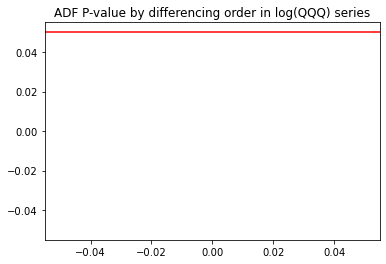

In [44]:
#graphing
plt.plot()
plt.title('ADF P-value by differencing order in log(QQQ) series')
plt.axhline(y=0.05,color='r')

In [46]:
# for col in df_prepd.columns:
#     print(col)
# display(df_postpd['RAY'])


Date
1999-03-10    3.933001
1999-03-11    3.937886
1999-03-12    3.913222
1999-03-15    3.941582
1999-03-16    3.950089
                ...   
2022-02-07    5.896384
2022-02-08    5.896384
2022-02-09    5.896384
2022-02-10    5.896384
2022-02-11    5.896384
Name: QQQ, Length: 5983, dtype: float64